# Experimenting with reading Xensr DAT files
Source https://kiteforum.com/viewtopic.php?t=2406619
This Jupyter notebook was used to experiment with reading Xensr files. 
- The good news is that the Python code *XensrDecoder.py* can now generate a GPX file from a DAT file 

- I was unable to make sense of the events data. I spent a long time trying to figure out the IMU data, using a test file where I had carefully controlled the inputs. It was possible to obtain the angular velocities around each axis (roll, pitch and yaw), but eventually I gave up on this.

In [607]:
%matplotlib inline
import struct
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import json
from geopy.geocoders import Nominatim


## Readlines


In [608]:
#fn = 'SESH003 210707.DAT'
#fn = 'SESH004 Bike.DAT'
#fn = 'SESH002 Hillhead.DAT'
#fn = 'SESH008 Test.DAT'
fn = 'SESH010 210728.DAT'
#fn = 'SESH024.DAT'
#fn = 'SESH001 3.DAT'

f = open(fn, 'rb')
data = f.readlines()

f.close()


# Structured data

## Header
    # header length = 132 bytes, little-endian '<'
    # 4 filetype
    # 2 major version
    # 2 minor version
    # 25 fileid
        # 13 id
        # 12 timestamp (2 year, 2 month, 2 day, 2 hour, 2 min, 2 sec)
    # 7 fillbytes/flags/options (zeroes)
    # 4 imudataoffset
    # 4 imudatabytes
    # 4 gpsdataoffset
    # 4 gpsdatabytes
    # 4 eventdataoffset
    # 4 eventdatabytes
    # 4 iddataoffset
    # 4 iddatabytes
    # 2 numberofevents
    # 2 sportmode (1002 kiteboarding)
    # 4 duration (seconds, divide by 100)
    # 6 timestampbinary
    # 46 padding

In [609]:
header_fmt = '<L 2H 25p 7x 8L 2H L 6B 46x'
header_len = struct.calcsize(header_fmt)

f = open(fn, 'rb')
data = f.read(header_len)
f.close()


header = struct.unpack(header_fmt, data)
header

(152389,
 1,
 9,
 b'a522d92ed96.210728104305',
 132,
 22626348,
 22626480,
 694512,
 23320992,
 280,
 23321272,
 357,
 7,
 0,
 629740,
 21,
 7,
 28,
 10,
 43,
 5)

##  JSON data

In [610]:
def getJSONOffset():
    return int(header[10])

def getJSONBytes():
    return int(header[11])

def getJSONData():
    fileHandle = open(fn, 'rb')
    fileHandle.seek(getJSONOffset(),0)

    data = fileHandle.read(getJSONBytes()).decode()
    fileHandle.close()

    #return json.dumps(json.loads(data), sort_keys=True)
    return json.loads(data)


In [611]:
jsonData = getJSONData()
jsonData

{'id': 'ea522d92ed96.210728104305',
 'timestamp': '210728104305',
 'duration': 628509,
 'sportMode': 0,
 'latitude': 50.78343,
 'longitude': -0.98239,
 'distance': 0.0,
 'maxSpeed': 0.0,
 'avgSpeed': 0.0,
 'startElevation': 0.0,
 'endElevation': 0.0,
 'maxElevation': 0.0,
 'minElevation': 0.0,
 'syncts': '000000000000',
 'timedelta': '0',
 'events': {'jumpCount': 6}}

In [612]:
jsonData['events']['jumpCount']

6

In [613]:
pd.to_datetime(f"20{jsonData['timestamp']}").strftime('%H:%M on %A %d %B %Y ')

'10:43 on Wednesday 28 July 2021 '

In [614]:
pd.to_datetime(jsonData['duration']*1e7).strftime('%H:%M')

'01:44'

In [615]:
  
# Initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")
  
# Assign Latitude & Longitude
#Latitude = str(jsonData['latitude'])
#Longitude = str(jsonData['longitude'])

# Get location with geocode
location = geolocator.geocode(f"{jsonData['latitude']},{jsonData['longitude']}").address
  
# Dsiplay location
print("\nLocation of the given Latitude and Longitude:")
print(location)


Location of the given Latitude and Longitude:
Sea Front, Sea View, South Hayling, Mengham, Havant, Hampshire, South East England, England, PO11 9EP, United Kingdom


In [616]:
add = location.split(',')
','.join(add[2:5]),add[-1]

(' South Hayling, Mengham, Havant', ' United Kingdom')

## Events
It looks like the last event is max speed, as is does not have items 4 onwards
If using <10L, then 
- 4 Height
- 4 Latitude offset
- 4 Longitude offset
- looking for hang time and impact, height, airtime, length, impact

In [617]:
#event_fmt = '<B 3l f l 4x f l B 8x'
event_fmt = '<B 3l f H 4x f 4x B 8x'
event_len = struct.calcsize(event_fmt)
event_unpack = struct.Struct(event_fmt).unpack_from

events = []

fileHandle = open(fn, 'rb')
fileHandle.seek(header[8],0)
data = fileHandle.read(header[9])
fileHandle.close()
events = struct.iter_unpack(event_fmt,data)
df = pd.DataFrame(events, columns=['Type', 'Timeoffset','Lat','Lon','Height (m)','Impact (g)','Airtime (s)','Inverted'])


In [618]:
#ev = np.array(list(events))
df['Timeoffset'] = df['Timeoffset'].divide(1e5)
df['Time into session'] = pd.to_datetime(df['Timeoffset'].astype('int'), unit='s').dt.time
df[['Lat','Lon']] = df[['Lat','Lon']].divide(1e7)
df['Impact (g)'] = df['Impact (g)'].divide(1e3).round(2) 
df[['Height (m)','Airtime (s)','Impact (g)']] = df[['Height (m)','Airtime (s)','Impact (g)']].round(2)
df

,Type,Timeoffset,Lat,Lon,Height (m),Impact (g),Airtime (s),Inverted,Time into session
0,1,2322.54915,50.780872,-0.984477,1.81,0.78,1.92,0,00:38:42
1,1,3271.14748,50.782877,-1.010220,2.42,1.29,6.07,0,00:54:31
2,1,3479.71300,50.783408,-1.012138,1.77,1.33,2.50,0,00:57:59
3,1,4734.32180,50.782113,-0.982868,1.65,1.02,5.80,0,01:18:54
4,1,5637.32277,50.781897,-0.982103,1.68,0.87,4.34,0,01:33:57
5,1,5789.78406,50.782022,-0.983278,3.13,1.24,5.52,0,01:36:29
6,2,-98.58800,-0.157333,0.002360,0.00,0.00,0.00,0,23:58:22


In [620]:
df.iloc[:,:-1]

,Type,Timeoffset,Lat,Lon,Height (m),Impact (g),Airtime (s),Inverted
0,1,2322.54915,50.780872,-0.984477,1.81,0.78,1.92,0
1,1,3271.14748,50.782877,-1.010220,2.42,1.29,6.07,0
2,1,3479.71300,50.783408,-1.012138,1.77,1.33,2.50,0
3,1,4734.32180,50.782113,-0.982868,1.65,1.02,5.80,0
4,1,5637.32277,50.781897,-0.982103,1.68,0.87,4.34,0
5,1,5789.78406,50.782022,-0.983278,3.13,1.24,5.52,0
6,2,-98.58800,-0.157333,0.002360,0.00,0.00,0.00,0


In [534]:
df.loc[df.Type==1,['Time into session','Height (m)','Airtime (s)','Impact (g)','Lat','Lon']]

#df.loc[df.Type==1,['Time into session','Height (m)','Airtime (s)','Impact (g)','Lat','Lon']].style.format({'Height (m)': "{:.2f}", 'Airtime (s)': '{:.2f}', 'Impact (g)': '{:.2f}'}) 

,Time into session,Height (m),Airtime (s),Impact (g),Lat,Lon
0,00:38:42,1.81,0.78,1.92,50.780872,-0.984477
1,00:54:31,2.42,1.29,6.07,50.782877,-1.010220
2,00:57:59,1.77,1.33,2.50,50.783408,-1.012138
3,01:18:54,1.65,1.02,5.80,50.782113,-0.982868
4,01:33:57,1.68,0.87,4.34,50.781897,-0.982103
5,01:36:29,3.13,1.24,5.52,50.782022,-0.983278


In [535]:
f"{df.loc[df.Type==1,'Height (m)'].max() :.2f} m"


'3.13 m'

In [538]:
dfEv = df
when = pd.to_datetime(f"20{jsonData['timestamp']}").strftime('%H:%M on %A %d %B %Y')
duration = pd.to_datetime(jsonData['duration']*1e7).strftime('%H:%M')
# Initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")
location = geolocator.geocode(f"{jsonData['latitude']},{jsonData['longitude']}")
highJump = f"{dfEv.loc[dfEv.Type==1,'Height (m)'].max() :.2f} m"
longAir = f"{dfEv.loc[dfEv.Type==1,'Airtime (s)'].max() :.2f} s"
dfSumm = pd.DataFrame([when, location,duration,highJump,longAir], index = ['When', "Where","Duration","Highest Jump","Longest Air"], columns=["Session"])
dfSumm  

,Session
When,10:43 on Wednesday 28 July 2021
Where,"(Sea Front, Sea View, South Hayling, Mengham, ..."
Duration,01:44
Highest Jump,3.13 m
Longest Air,1.33 s


In [226]:
event_fmt = '<B 3l l 23x'
event_len = struct.calcsize(event_fmt)
event_unpack = struct.Struct(event_fmt).unpack_from

events = struct.iter_unpack(event_fmt,data[-40:])
list(events)

[(2, 0, -2147483648, 56966, 45005656)]

In [227]:
int(data[-31:-29])

ValueError: invalid literal for int() with base 10: b'\x86\xde'

In [278]:
df[:-1].describe()

,Type,Timeoffset,Lat,Lin,Height,unk,Airtime,Impact,Inverted
count,25.0,2.500000e+01,2.500000e+01,2.500000e+01,25.000000,25.000000,25.0,25.000000,25.000000
mean,1.0,4.524680e+08,5.078037e+08,-9.999690e+06,2.165323,1082.400000,0.0,3.880671,0.200000
std,0.0,2.200846e+08,1.722146e+04,9.194510e+04,0.521162,374.422222,0.0,1.350429,0.408248
min,1.0,1.438848e+08,5.077526e+08,-1.006810e+07,1.575048,412.000000,0.0,1.091905,0.000000
25%,1.0,3.009325e+08,5.077990e+08,-1.005210e+07,1.903023,923.000000,0.0,3.118810,0.000000
50%,1.0,4.000665e+08,5.078104e+08,-1.004023e+07,2.106065,1129.000000,0.0,4.085472,0.000000
75%,1.0,5.639593e+08,5.078139e+08,-1.002323e+07,2.307558,1284.000000,0.0,4.757938,0.000000
max,1.0,9.106962e+08,5.078230e+08,-9.808133e+06,3.490102,1718.000000,0.0,6.171915,1.000000


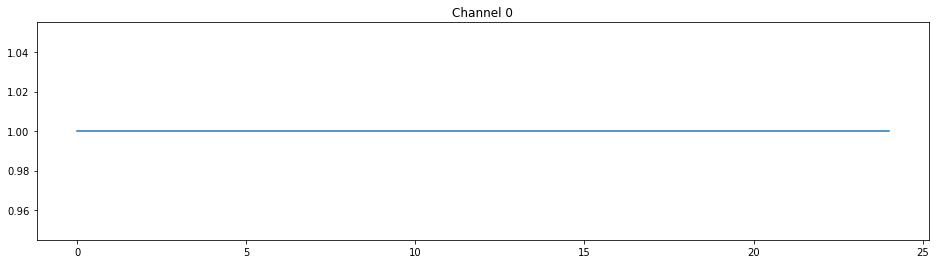

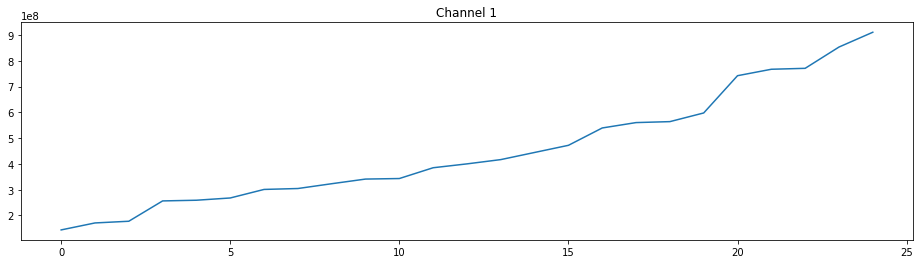

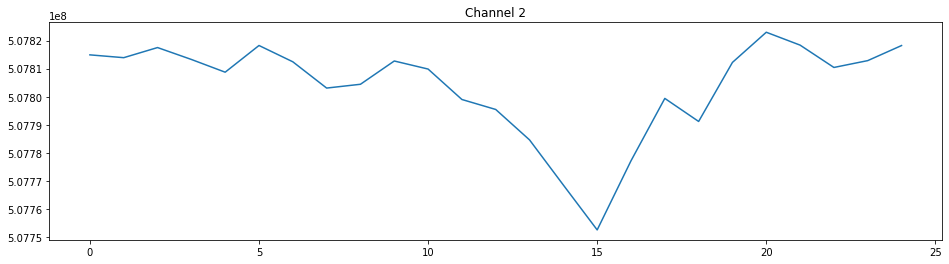

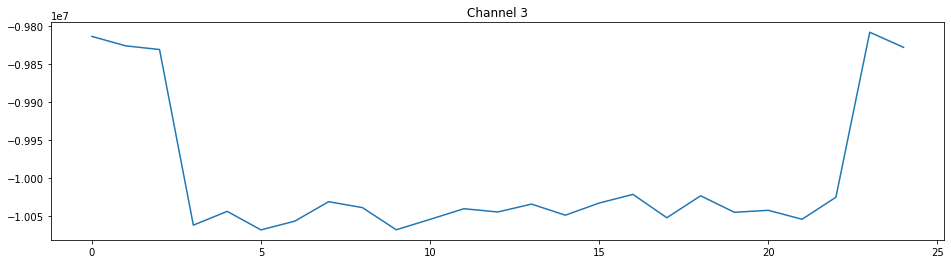

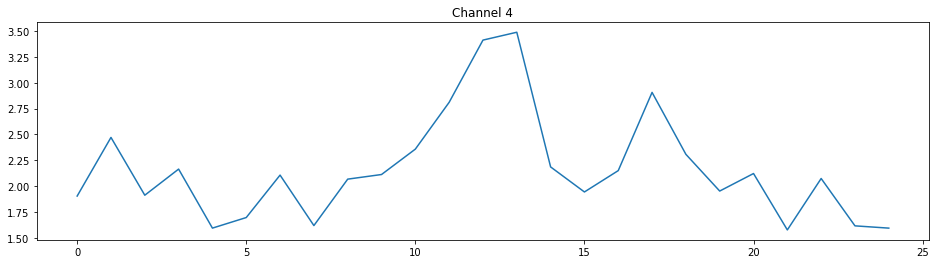

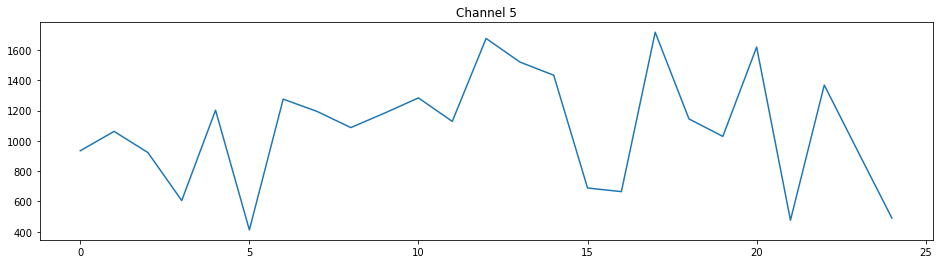

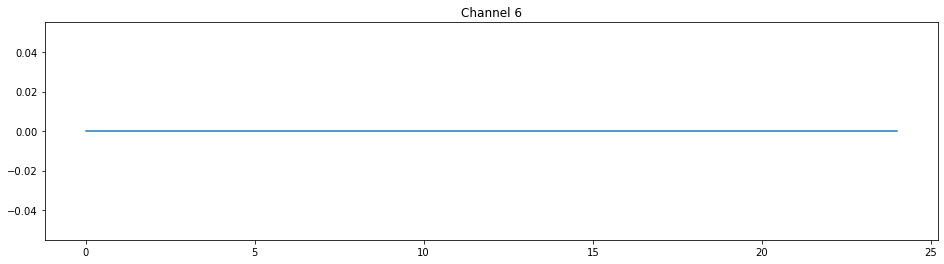

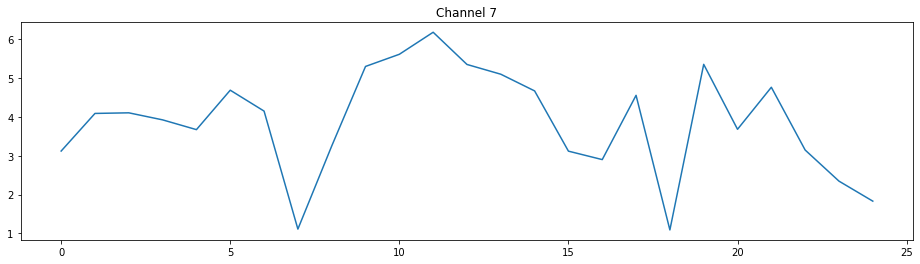

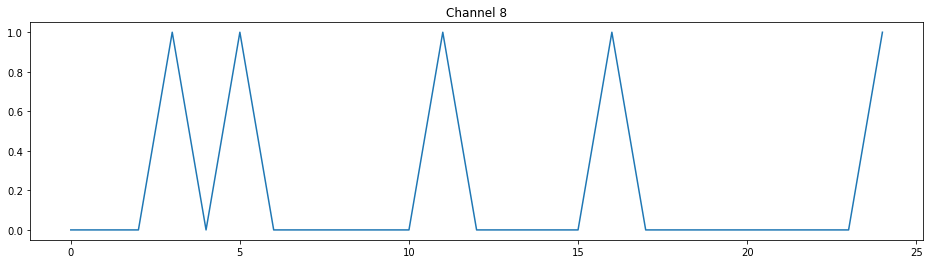

In [279]:
for i in range(len(df.columns)):
    df.iloc[:-1,i].plot(figsize=(16,4), title=f'Channel {i}')
    plt.show()

In [280]:
df[:-1].corr()

,Type,Timeoffset,Lat,Lin,Height,unk,Airtime,Impact,Inverted
Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Timeoffset,NaN,1.000000,0.019541,0.040589,-0.166486,-0.049329,NaN,-0.262289,0.044969
Lat,NaN,0.019541,1.000000,0.281878,-0.326604,-0.124196,NaN,0.055187,0.044470
Lin,NaN,0.040589,0.281878,1.000000,-0.247685,-0.266243,NaN,-0.370942,-0.023385
Height,NaN,-0.166486,-0.326604,-0.247685,1.000000,0.631734,NaN,0.488495,-0.081107
unk,NaN,-0.049329,-0.124196,-0.266243,0.631734,1.000000,NaN,0.246133,-0.575155
Airtime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Impact,NaN,-0.262289,0.055187,-0.370942,0.488495,0.246133,NaN,1.000000,0.007675
Inverted,NaN,0.044969,0.044470,-0.023385,-0.081107,-0.575155,NaN,0.007675,1.000000


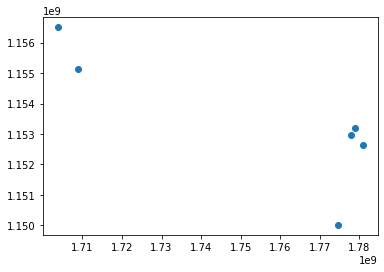

In [13]:
# These are definitely some kind of lon/lat offsets as the points mark the correct positions of jumps.
plt.scatter(df.iloc[:-1,2],df.iloc[:-1,1])

<AxesSubplot:>

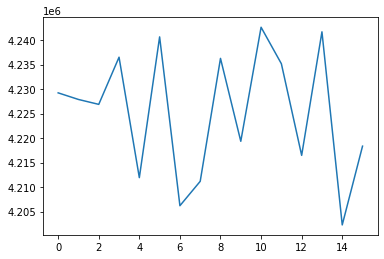

In [13]:
df.iloc[:-1,6].plot()

In [14]:
#for i in ev.T:
#    fig,ax = plt.subplots(figsize=(12,12))
#    ax.bar(range(26),height=i[:-1]);


## GPS path

In [385]:
#gps_fmt = '<4i 3H 2B'
gps_fmt = '<6l'
gps_len = struct.calcsize(gps_fmt)
gps_unpack = struct.Struct(gps_fmt).unpack_from

gps = []

fileHandle = open(fn, 'rb')
fileHandle.seek(header[6],0)
data = fileHandle.read(header[7])
fileHandle.close()
gps = struct.iter_unpack(gps_fmt,data)


## Analyse gp 
- element 2 increments slowly up to 110
- element 3 is 1/256 of element 2
- element 2 increments from 0 to 1 at row 729 and around every 764 rows
- suggested format
     - 4 timeoffset in ms
     - 4 ??altitude?
     - 4 latitude * 10000000
     - 4 longitude * 10000000
     - 4 speed m/s * 10000000    ***Need to multiply by 1.5 to get m/s
     - 4 altitude * 1e7
     


In [386]:
# convert your array into a dataframe
df = pd.DataFrame (gps)
df.head()

,0,1,2,3,4,5
0,75479,0,514806983,-2425066,0,532168
1,75757,82,514806983,-2425066,21,532168
2,76206,82,514806983,-2425066,21,532168
3,95378,82,514806983,-2425066,21,532168
4,115041,82,514806983,-2425066,21,532168


In [387]:

## save to xlsx file

#filepath = 'XensrTemp.xlsx'

#df.to_excel(filepath)

In [388]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 3 * IQR)) |(df > (Q3 + 3 * IQR)))
    return trueList


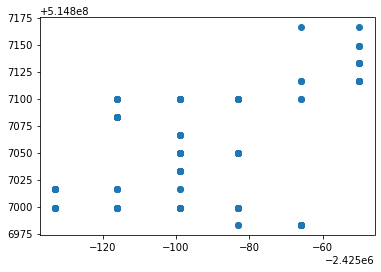

In [389]:
df2 = df[Remove_Outlier_Indices(df)]
#df2.to_excel(filepath)
plt.scatter(df2[3],df2[2])


In [20]:
df2.describe()

,0,1,2,3,4,5
count,2.465600e+04,24631.000000,2.455600e+04,2.455500e+04,2.465200e+04,2.452300e+04
mean,2.704516e+08,16.593967,5.080995e+08,-1.223392e+07,2.960630e+07,8.103832e+05
std,1.560782e+08,62.786906,1.663724e+04,1.639119e+04,1.348039e+07,7.363566e+04
min,7.551000e+04,-265.000000,5.080532e+08,-1.227307e+07,0.000000e+00,4.610320e+05
25%,1.354722e+08,-20.000000,5.080880e+08,-1.224601e+07,2.634548e+07,7.522280e+05
50%,2.706306e+08,15.000000,5.081008e+08,-1.223177e+07,3.276801e+07,8.014990e+05
75%,4.051036e+08,63.000000,5.081134e+08,-1.222412e+07,3.774874e+07,8.677320e+05
max,5.410945e+08,195.000000,5.081305e+08,-1.218728e+07,6.828852e+07,1.004330e+06


<AxesSubplot:>

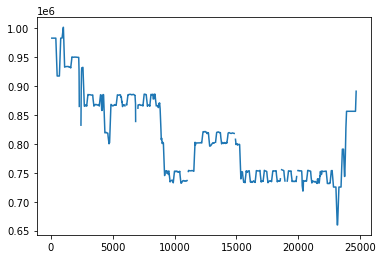

In [21]:
# Not clear what this is
df2[5].rolling(100).mean().plot()

<AxesSubplot:>

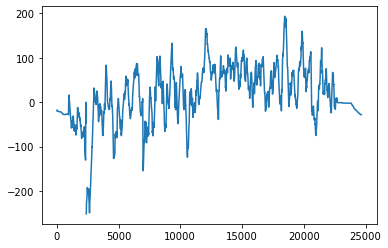

In [22]:
#Best guess for altitude remove outliers and divide by 10 to get altitude in m
df2[1].rolling(10).mean().plot()

<AxesSubplot:>

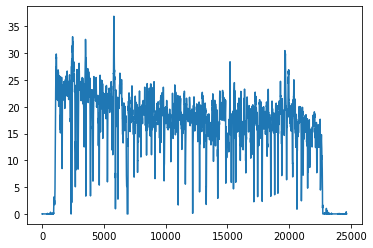

In [23]:
# This gives speed in kph (multiply by 1.5 to get m/s then 3.6 to get kph)
df2[4].rolling(1).mean().multiply(1.5*3.6*1e-7).plot()

As a sense check, calculate speed from change in lon/lat coordinates

In [24]:
cos = np.cos(df2[2].mean()/1e7/180*np.pi)
df2['Speed from coords']=(df2[3].multiply(cos).diff(4)**2+df2[2].diff(4)**2)**0.5/df2[0].diff(4)*100000/90*3.6

In [25]:
cos

0.631894720107787

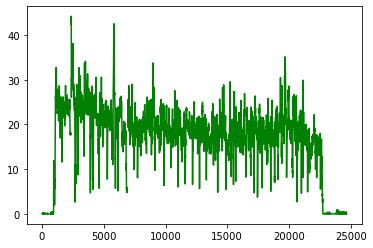

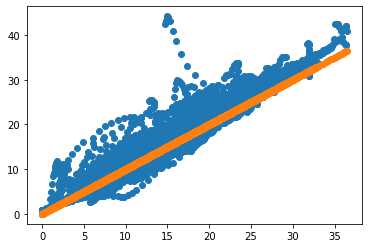

In [26]:
plt.plot(df2['Speed from coords'].rolling(10).mean(),c='g')
plt.show()
plt.scatter(df2[4].multiply(1.5*3.6e-7).rolling(10).mean(),df2['Speed from coords'].rolling(10).mean(),)
plt.scatter(df2[4].multiply(1.5*3.6e-7).rolling(10).mean(),df2[4].multiply(1.5*3.6e-7).rolling(10).mean())


## Function to convert local time to UCT for ISO spec of GPX file
- Designed to work for anywhere in the world
- https://www.topografix.com/gpx_manual.asp#time
- Date and time in are in Univeral Coordinated Time (UTC), not local time! Conforms to ISO 8601 specification for date/time representation.


In [27]:
import pytz
from datetime import datetime, timedelta
from tzwhere import tzwhere

def timezone_offset(latitude, longitude, dt):
    """To comply with GPX standard, local time must be converted to UCT.
    This runs rather slowly - 4/5 seconds.
    Returns the datetime.timedelta offset that must by deducted to obtain UCT"""
    tzw = tzwhere.tzwhere(forceTZ=True)
    timezone_str = tzw.tzNameAt(latitude, longitude,forceTZ=True)
    timezone = pytz.timezone(timezone_str)
    timezone_aware_datetime = timezone.localize(dt, is_dst=None)
    timeOffset = timezone_aware_datetime.utcoffset()
    return timeOffset

dt = datetime(year=2021, month=7, day=17, hour=12, minute=0, second=0)
timezone_offset(latitude=39.747854, longitude=40.004733, dt=dt)

/Users/Gavin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


datetime.timedelta(seconds=10800)

In [28]:
latitude = jsonData['latitude']
longitude = jsonData['longitude']
dt = datetime.strptime(jsonData['timestamp'],'%y%m%d%H%M%S')
tz_offset = timezone_offset(latitude, longitude, dt=dt)
tz_offset

datetime.timedelta(seconds=3600)

### First calculate columns and then quantize time to 1 Hz

In [29]:
df2['time2'] = df2[0]/1e5
df2['time'] = df2['time2'].apply(lambda x: f'{(timedelta(seconds=int(x)) + dt - tz_offset).isoformat()}Z')
df2['lat'] = df2[2]/1e7
df2['lon'] = df2[3]/1e7
df2['ele'] = df2[1]/10
df2['speed'] = df2[4]/1e7*1.5



In [30]:
df2 = df2.set_index('time2',drop=False)
seconds = range(int(df2.index.max())+1)
df2 = df2.append(pd.DataFrame(seconds)).sort_index()

df2 = df2.fillna(method='backfill')

In [31]:
df2.head(20)

,0,1,2,3,4,5,Speed from coords,ele,lat,lon,speed,time,time2
0.00000,0,0.0,508130449.0,-12224933.0,0.0,983040.0,0.0,0.0,50.813045,-1.222493,0.000000e+00,2021-06-11T13:46:47Z,0.75510
0.75510,75510,0.0,508130449.0,-12224933.0,0.0,983040.0,0.0,0.0,50.813045,-1.222493,0.000000e+00,2021-06-11T13:46:47Z,0.75510
0.75877,75877,-20.0,508130449.0,-12224933.0,6.0,983040.0,0.0,-2.0,50.813045,-1.222493,9.000000e-07,2021-06-11T13:46:47Z,0.75877
0.76254,76254,-20.0,508130449.0,-12224933.0,6.0,983040.0,0.0,-2.0,50.813045,-1.222493,9.000000e-07,2021-06-11T13:46:47Z,0.76254
0.85538,85538,-20.0,508130449.0,-12224933.0,6.0,983040.0,0.0,-2.0,50.813045,-1.222493,9.000000e-07,2021-06-11T13:46:47Z,0.85538
1.00000,1,-20.0,508130449.0,-12224933.0,6.0,983040.0,0.0,-2.0,50.813045,-1.222493,9.000000e-07,2021-06-11T13:46:48Z,1.25095
1.25095,125095,-20.0,508130449.0,-12224933.0,6.0,983040.0,0.0,-2.0,50.813045,-1.222493,9.000000e-07,2021-06-11T13:46:48Z,1.25095
1.46313,146313,-20.0,508130449.0,-12224933.0,6.0,983040.0,0.0,-2.0,50.813045,-1.222493,9.000000e-07,2021-06-11T13:46:48Z,1.46313
2.00000,2,-20.0,508130449.0,-12224933.0,6.0,983040.0,0.0,-2.0,50.813045,-1.222493,9.000000e-07,2021-06-11T13:46:49Z,2.45277
2.45277,245277,-20.0,508130449.0,-12224933.0,6.0,983040.0,0.0,-2.0,50.813045,-1.222493,9.000000e-07,2021-06-11T13:46:49Z,2.45277


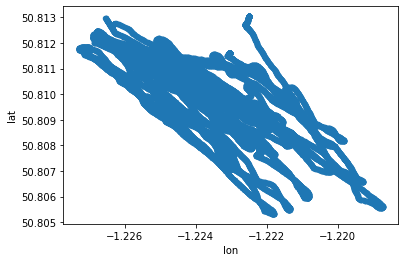

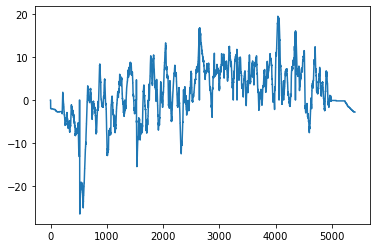

<AxesSubplot:>

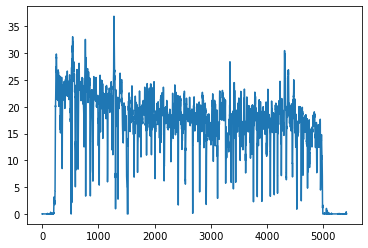

In [32]:
df2.plot.scatter('lon','lat')
plt.show()
df2['ele'].plot()
plt.show()
df2['speed'].multiply(3.6).plot()

In [33]:
df2['gpx'] = df2.apply(lambda x: f'<trkpt lon="{x.lon}" lat="{x.lat}">\n<ele>{x.ele}</ele>\n<time>{x.time}</time>\n</trkpt>\n',axis=1)

In [34]:
df2 = df2.loc[seconds]

In [35]:
gpx_header = '<?xml version="1.0"?>\n<gpx xmlns="http://www.topografix.com/GPX/1/1" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd http://www.garmin.com/xmlschemas/TrackPointExtension/v1 http://www.garmin.com/xmlschemas/TrackPointExtensionv1.xsd http://www.garmin.com/xmlschemas/PowerExtension/v1 http://www.garmin.com/xmlschemas/PowerExtensionv1.xsd" xmlns:gpxtpx="http://www.garmin.com/xmlschemas/TrackPointExtension/v1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" creator="Gavin Francis" version="1.1" xmlns:gpxpx="http://www.garmin.com/xmlschemas/PowerExtension/v1">\n<trk>\n<trkseg>\n'
gpx_footer = '</trkseg>\n</trk>\n</gpx>'

gpx_header

'<?xml version="1.0"?>\n<gpx xmlns="http://www.topografix.com/GPX/1/1" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd http://www.garmin.com/xmlschemas/TrackPointExtension/v1 http://www.garmin.com/xmlschemas/TrackPointExtensionv1.xsd http://www.garmin.com/xmlschemas/PowerExtension/v1 http://www.garmin.com/xmlschemas/PowerExtensionv1.xsd" xmlns:gpxtpx="http://www.garmin.com/xmlschemas/TrackPointExtension/v1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" creator="Gavin Francis" version="1.1" xmlns:gpxpx="http://www.garmin.com/xmlschemas/PowerExtension/v1">\n<trk>\n<trkseg>\n'

In [36]:
gpxfile = f"{fn.split('.')[0]} test.GPX"
f = open(gpxfile, "w")
f.write(gpx_header)
for item in  df2.loc[seconds,'gpx'].values:
    f.write(item)
f.write(gpx_footer)
f.close()


## IMU data
 - 4 time offset milliseconds *100
 - Looking for pitch roll and yaw, but we have 8 values
 
 I created a test file using this test protocol *SESH008 Test.DAT*
- X axis move forward and back 
- Y axis move Left and right
- Z axis up and down
- Roll twice to R then L
- Yaw twice clockwise then anti
- Pitch twice forwards once back


In [37]:
imu_fmt = '<L 16h '#<4l 8H l'    # 9l
imu_len = struct.calcsize(imu_fmt)
imu_unpack = struct.Struct(imu_fmt).unpack_from

imu = []

fileHandle = open(fn, 'rb')
fileHandle.seek(header[4],0)
data = fileHandle.read(header[5]//36*36)
fileHandle.close()
imu = struct.iter_unpack(imu_fmt,data)

im = np.array(list(imu))
df = pd.DataFrame(im[:-3])

In [38]:
#df = df[Remove_Outlier_Indices(df)]

In [39]:
imu_len

36

### Channels - X is direction of travel (roll axis), Y is right/left (pitch axis), Z is up/down (yaw axis) LH rule
- Channel 0 L is time in centiseconds
- Next 16 channels are h
- Channel 1 pitch (dirn of X axis to horizontal) positive is up negative is down (or up in reverse direction), with some X,Y and Z
- Channel 2 is roll (dirn of Y axis to horizontal) positive is to the right and negative is left, with some Y and Z
- Channel 3 picks up devaitions from horizontal (pitch or roll) with some Z, orientation of the Z axis where positive is down 
- Channel 4 is roll velocity (positive is clockwise, negative is anti, using RH grip rule) cumulative gives angle
- Channel 5 is pitch velociy (positive is up, negative is down) cumulative gives angle
- Channel 6 is yaw velocity (postive is clockwise, negative is anti, using RH grip rule, cumulative gives angle
- Channel 7 seems to be yaw minus roll
- Channel 8 seems to be yaw minus pitch
- Channel 9 picks up devaitions from horizontal (pitch or roll) like channel 3, 14, 15
- Channel 10 is inverse altitude
- Channels 11,12 look like noise
- Channel 13 accumulates rotations of the unit along all axes like channel 16
- Channels 14 and 15  from horizontal (pitch or roll) like channels 3 and 9
- Channel 16 accumulates rotations of the unit along all axes like channel 13

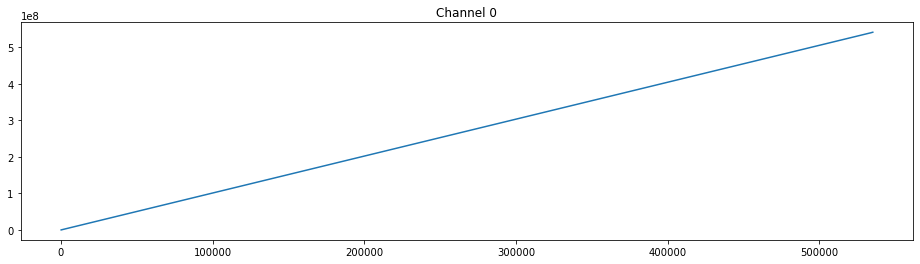

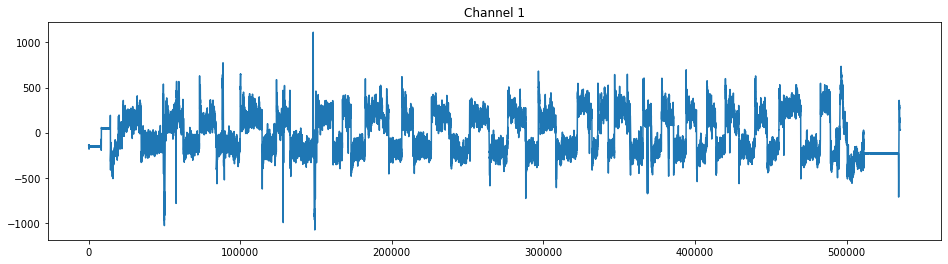

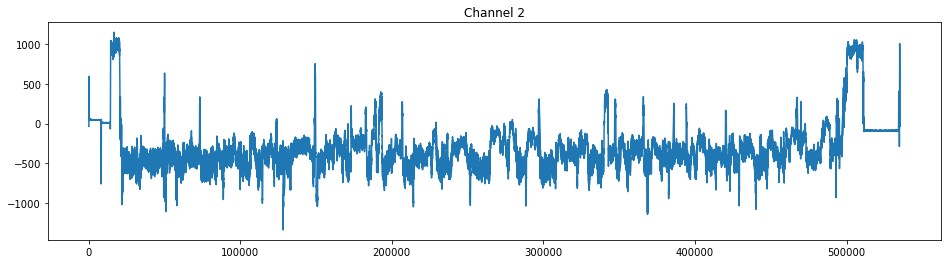

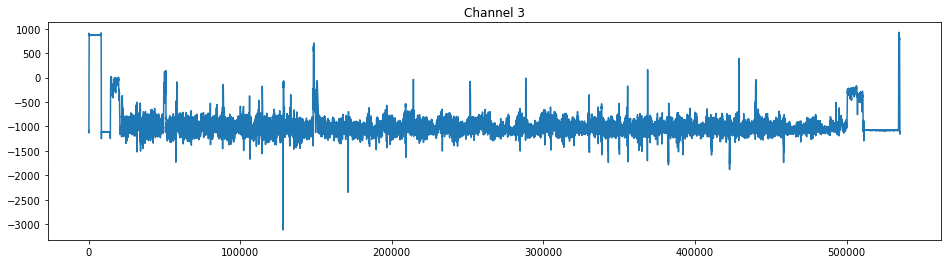

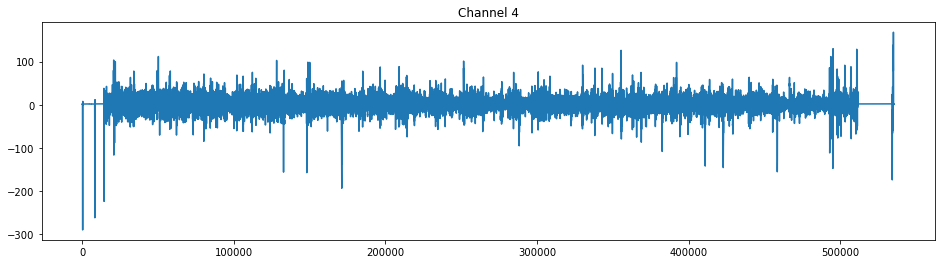

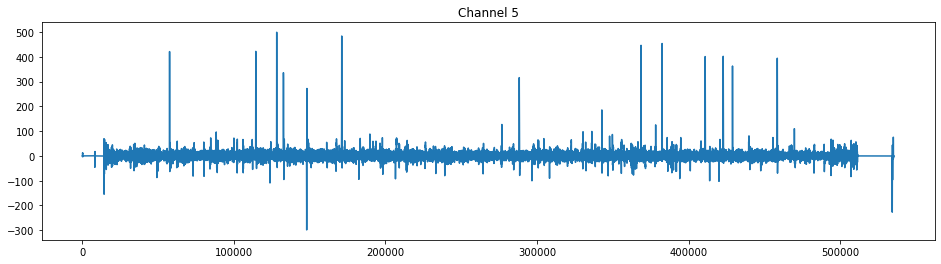

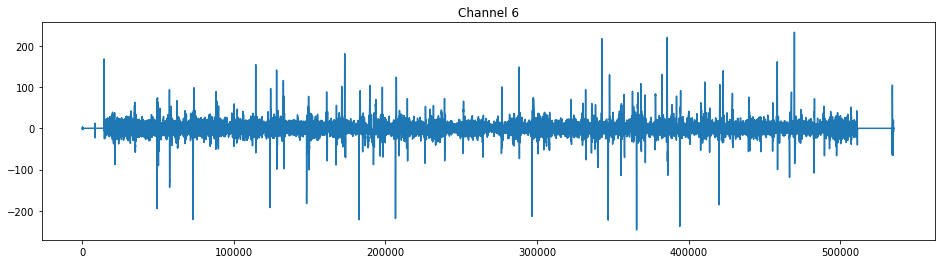

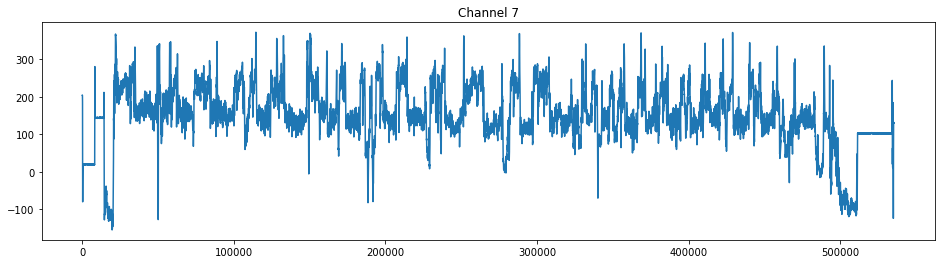

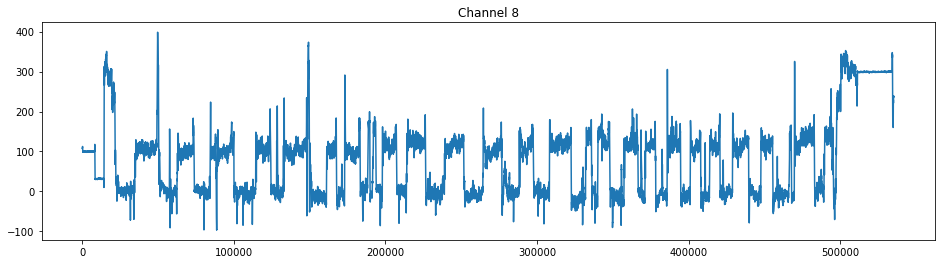

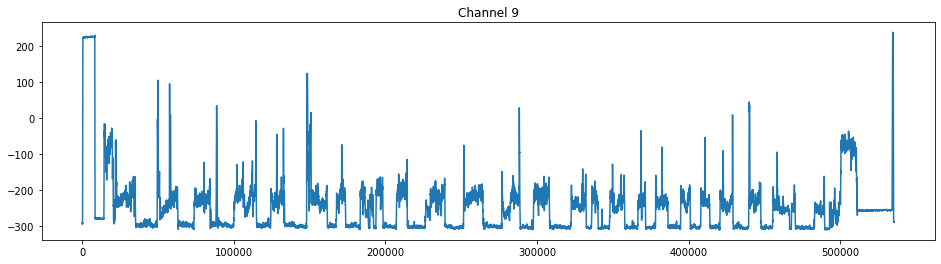

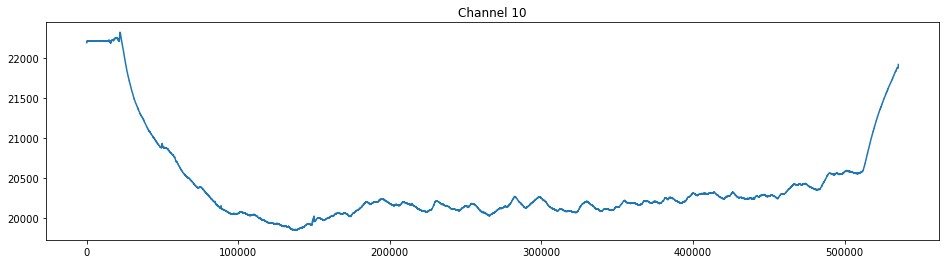

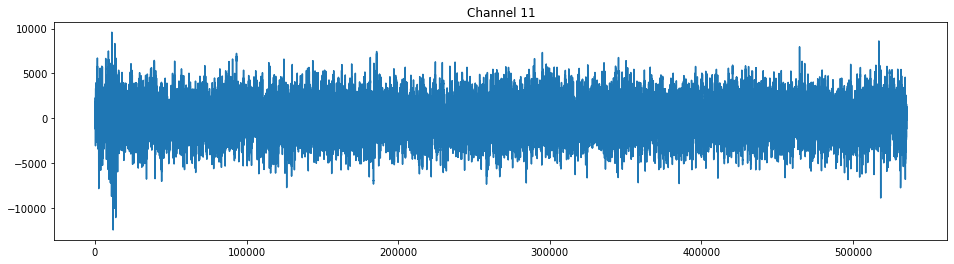

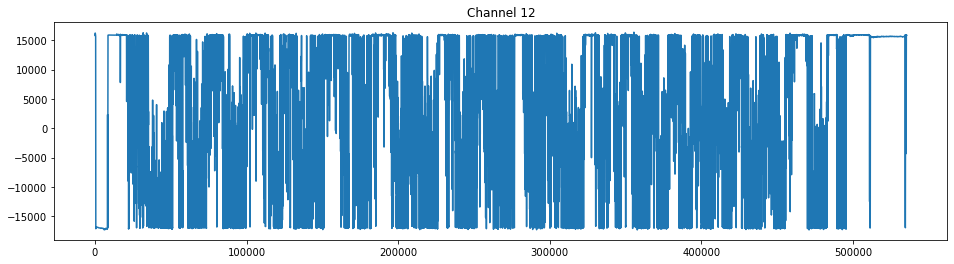

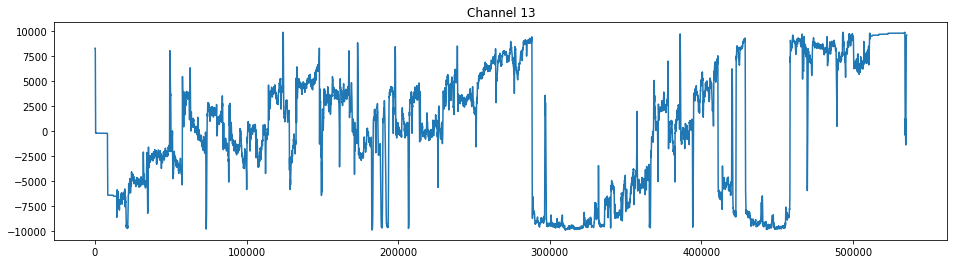

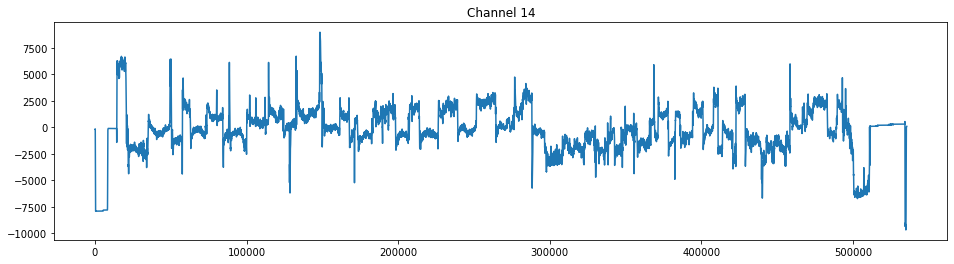

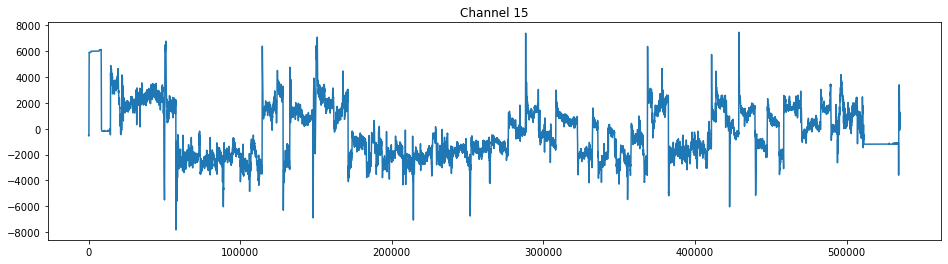

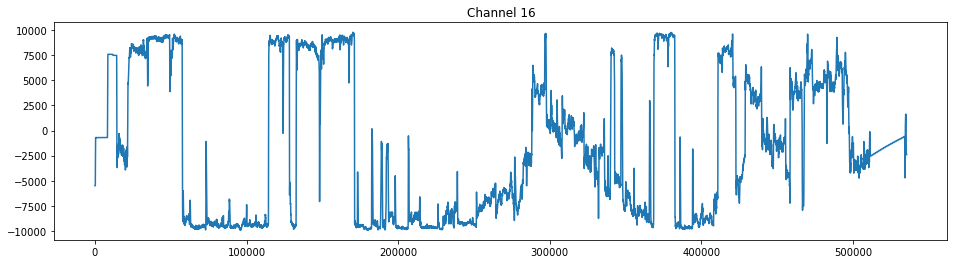

In [40]:
for i in range(len(df.columns)):
    df.loc[:,i].rolling(100).mean().plot(figsize=(16,4), title=f'Channel {i}')
    plt.show()

In [41]:
df[29000:].corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.000000,-0.042539,0.243831,0.011730,-0.001747,-0.002515,0.004403,-0.369735,0.322405,0.045756,0.203426,-0.000022,0.108266,0.152895,-0.198600,0.076593,0.068152
1,-0.042539,1.000000,-0.153494,-0.001658,-0.023029,0.182267,-0.081733,0.133482,-0.339806,0.110698,-0.069553,-0.000413,0.233340,-0.034187,0.074404,-0.043452,-0.030546
2,0.243831,-0.153494,1.000000,0.337501,-0.116984,-0.027801,0.088960,-0.484109,0.358090,0.079925,0.132159,0.000038,0.176411,0.135229,-0.218168,0.078791,0.034639
3,0.011730,-0.001658,0.337501,1.000000,0.020387,-0.020393,0.041751,0.055659,0.055573,0.270360,0.031468,-0.000303,0.192613,0.015066,-0.066530,0.010518,-0.002356
4,-0.001747,-0.023029,-0.116984,0.020387,1.000000,-0.047816,-0.115206,-0.036931,-0.009142,-0.007392,0.004043,0.001077,0.018076,-0.001832,0.005707,-0.001036,0.001035
5,-0.002515,0.182267,-0.027801,-0.020393,-0.047816,1.000000,-0.240636,0.058792,0.001076,0.075061,-0.013809,-0.001009,0.039050,-0.006064,0.010426,0.009502,0.001695
6,0.004403,-0.081733,0.088960,0.041751,-0.115206,-0.240636,1.000000,0.030412,-0.009232,0.022837,-0.006843,0.000827,0.026509,-0.003574,-0.002952,-0.016298,-0.003640
7,-0.369735,0.133482,-0.484109,0.055659,-0.036931,0.058792,0.030412,1.000000,-0.503223,0.213041,-0.167574,0.000847,-0.063551,-0.169990,0.290785,-0.195736,-0.068516
8,0.322405,-0.339806,0.358090,0.055573,-0.009142,0.001076,-0.009232,-0.503223,1.000000,-0.165855,0.387408,-0.000963,-0.112038,0.196182,-0.240339,0.097589,0.083271
9,0.045756,0.110698,0.079925,0.270360,-0.007392,0.075061,0.022837,0.213041,-0.165855,1.000000,0.129085,-0.001055,0.318082,0.138761,-0.107705,-0.061633,-0.078938


Also plot cumulative values, 

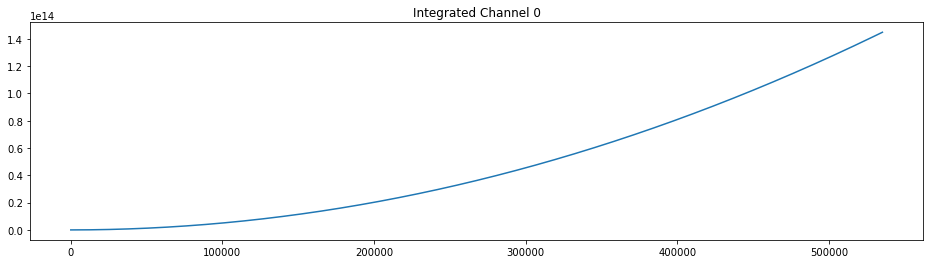

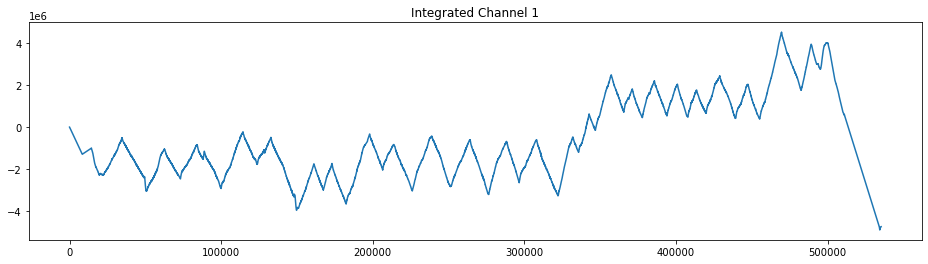

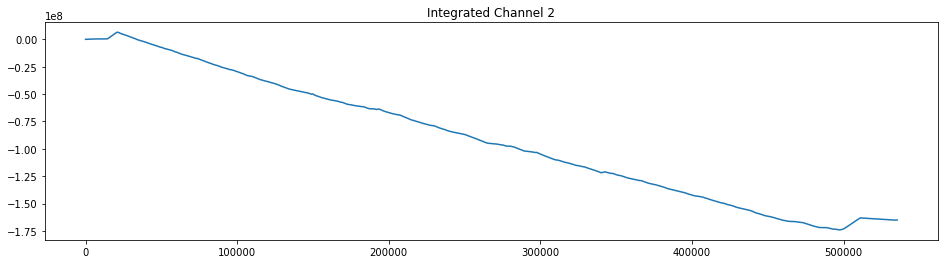

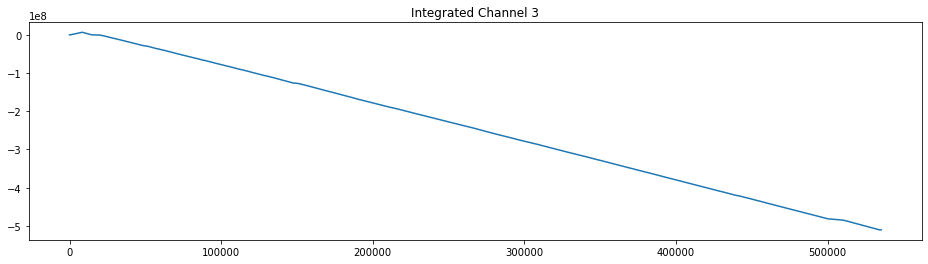

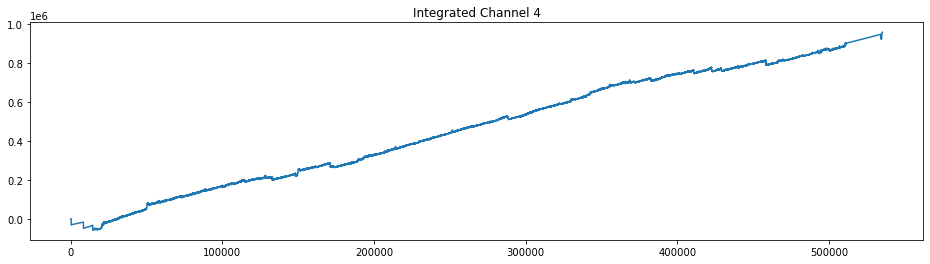

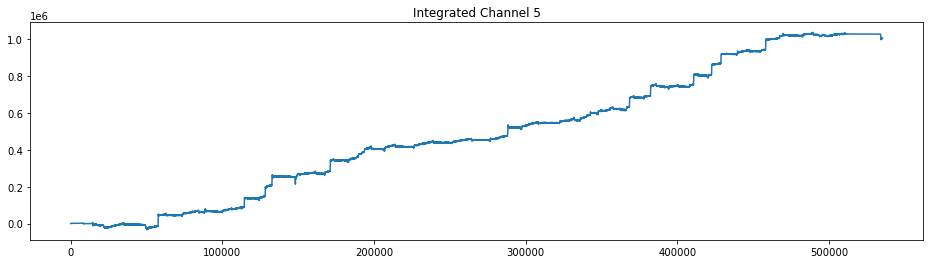

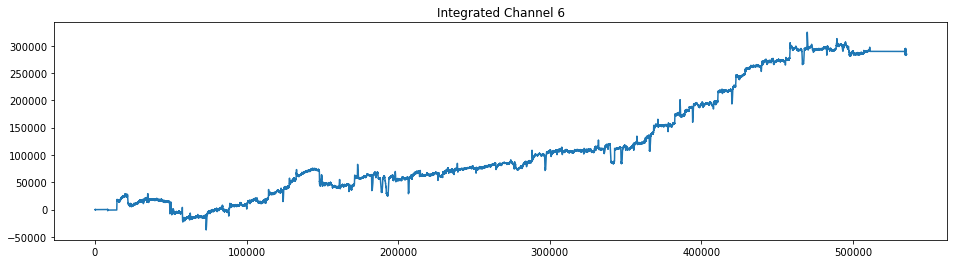

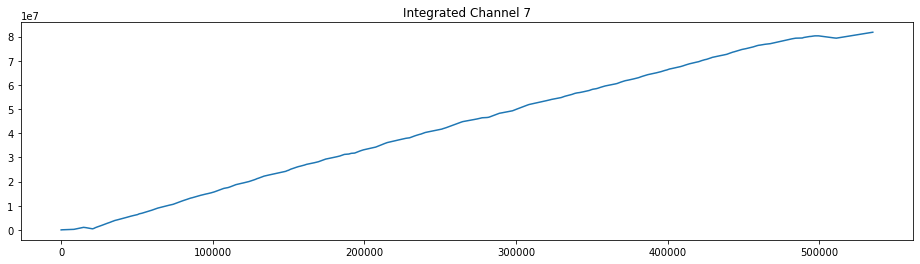

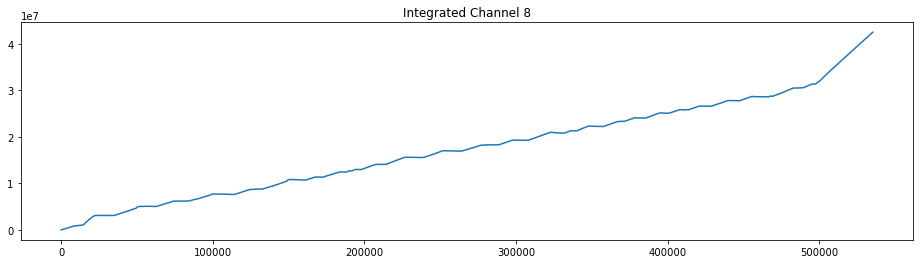

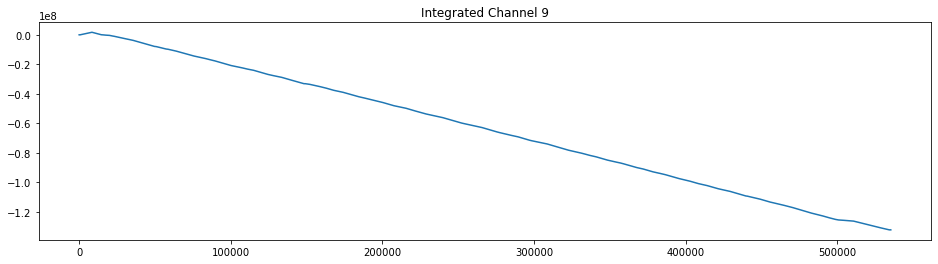

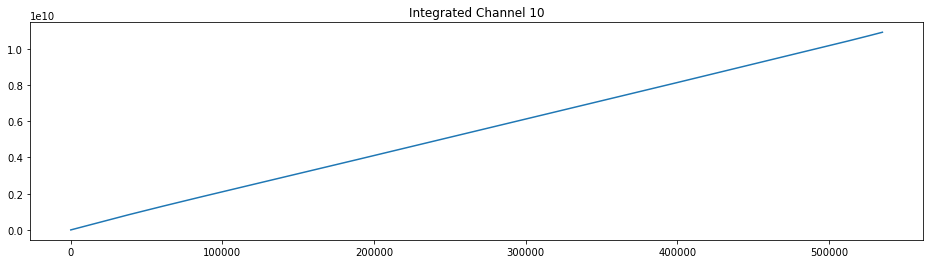

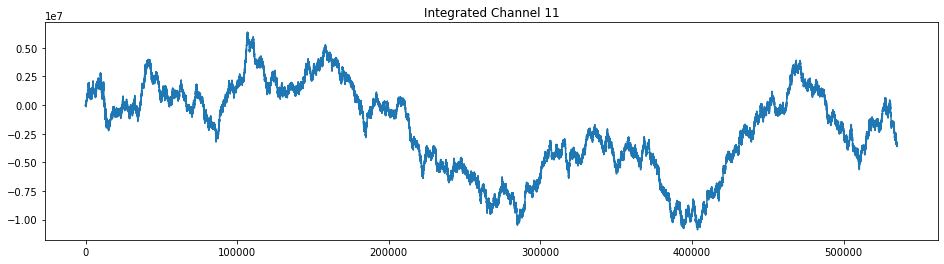

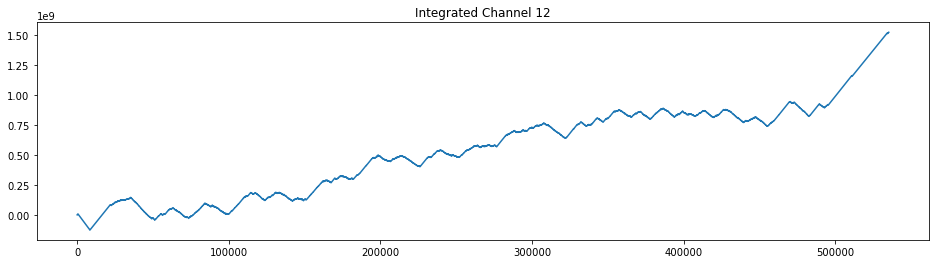

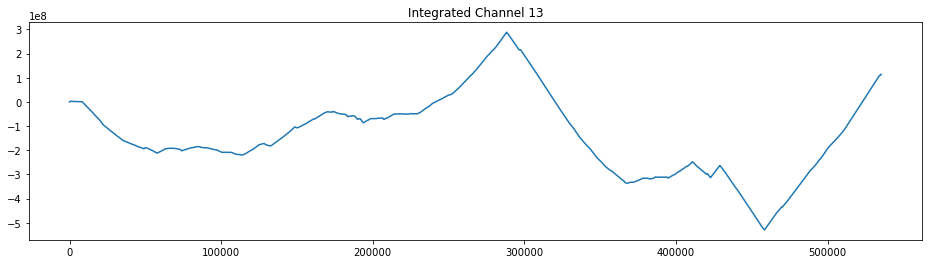

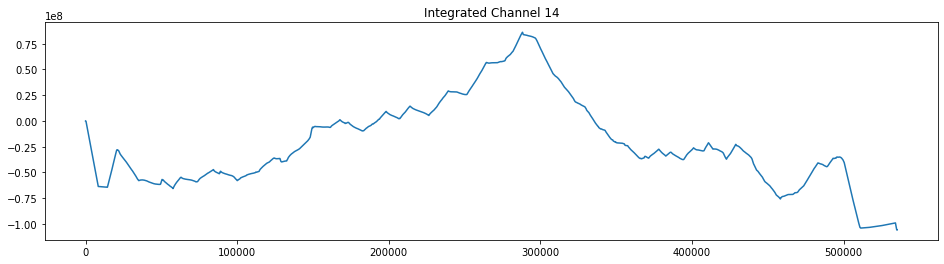

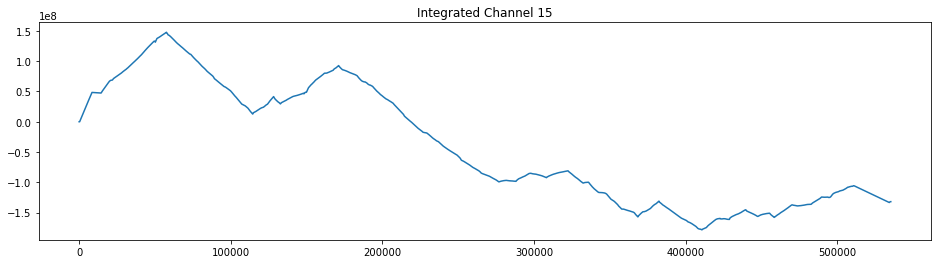

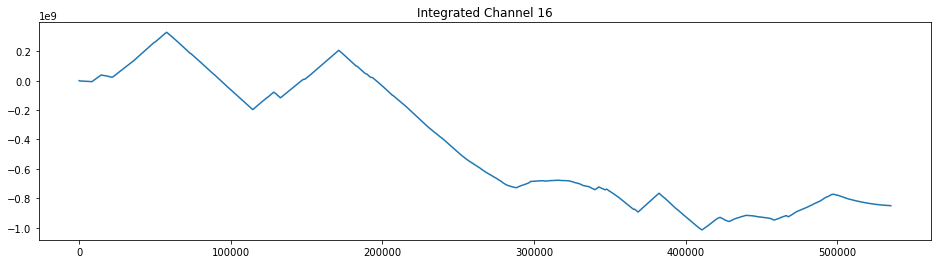

In [42]:
for i in range(len(df.columns)):
    df.loc[:,i].rolling(1).mean().cumsum().plot(figsize=(16,4), title=f'Integrated Channel {i}')
    plt.show()

In [43]:
df.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.000000,-0.028517,0.125196,-0.093825,0.000895,0.001472,0.004054,-0.224041,0.255850,-0.163821,-0.182682,0.000134,0.090357,0.208040,-0.092012,-0.078829,0.004458
1,-0.028517,1.000000,-0.170313,-0.034216,-0.017281,0.182849,-0.083194,0.148181,-0.342584,0.030719,-0.065447,-0.000824,0.225695,-0.031399,0.064059,-0.062584,-0.022264
2,0.125196,-0.170313,1.000000,0.372792,-0.112602,-0.034837,0.089522,-0.541409,0.396603,0.177237,0.246389,0.000211,0.182389,0.078501,-0.114525,0.155397,0.033097
3,-0.093825,-0.034216,0.372792,1.000000,0.014792,-0.029733,0.040440,-0.079102,0.093609,0.465397,0.222384,0.000715,0.128811,-0.006367,-0.174328,0.181257,0.001136
4,0.000895,-0.017281,-0.112602,0.014792,1.000000,-0.040095,-0.126464,-0.032545,-0.009464,-0.008972,-0.002179,0.001268,0.017548,-0.001721,0.007464,-0.004509,0.000561
5,0.001472,0.182849,-0.034837,-0.029733,-0.040095,1.000000,-0.241858,0.053715,-0.000384,0.045286,-0.016410,-0.001017,0.034537,-0.003556,0.009848,0.005021,0.000993
6,0.004054,-0.083194,0.089522,0.040440,-0.126464,-0.241858,1.000000,0.025581,-0.008566,0.014404,-0.004621,0.000692,0.028461,-0.003433,0.000444,-0.014309,-0.003373
7,-0.224041,0.148181,-0.541409,-0.079102,-0.032545,0.053715,0.025581,1.000000,-0.531770,-0.076358,-0.265167,0.000016,-0.055271,-0.117917,0.187719,-0.282488,-0.043950
8,0.255850,-0.342584,0.396603,0.093609,-0.009464,-0.000384,-0.008566,-0.531770,1.000000,-0.039279,0.300097,-0.000309,-0.092225,0.163211,-0.125205,0.131868,0.055422
9,-0.163821,0.030719,0.177237,0.465397,-0.008972,0.045286,0.014404,-0.076358,-0.039279,1.000000,0.432433,0.000987,0.122779,0.055000,-0.311534,0.276409,-0.037080


In [589]:
df['n']=df.apply(lambda x: x.index+1)
df.apply(lambda x: f"Jump {x.n}: Height {x['Height (m)']}m Airtime {x['Airtime (s)']}s Impact {x['Impact (g)']}g",axis=1)

0    Jump 1: Height 1.81m Airtime 0.78s Impact 1.92g
1    Jump 2: Height 2.42m Airtime 1.29s Impact 6.07g
2     Jump 3: Height 1.77m Airtime 1.33s Impact 2.5g
3     Jump 4: Height 1.65m Airtime 1.02s Impact 5.8g
4    Jump 5: Height 1.68m Airtime 0.87s Impact 4.34g
5    Jump 6: Height 3.13m Airtime 1.24s Impact 5.52g
6       Jump 7: Height 0.0m Airtime 0.0s Impact 0.0g
dtype: object

In [606]:
[i for i in range(1,7)]

[1, 2, 3, 4, 5, 6]

In [594]:
df[['Height','Airtime','Impact']]=df[['Height (m)','Airtime (s)','Impact (g)']]

In [595]:
df

,Type,Timeoffset,Lat,Lon,Height (m),Airtime (s),Impact (g),Inverted,Time into session,n,Height,Airtime,Impact
0,1,2322.54915,50.780872,-0.984477,1.81,0.78,1.92,0,00:38:42,1,1.81,0.78,1.92
1,1,3271.14748,50.782877,-1.010220,2.42,1.29,6.07,0,00:54:31,2,2.42,1.29,6.07
2,1,3479.71300,50.783408,-1.012138,1.77,1.33,2.50,0,00:57:59,3,1.77,1.33,2.50
3,1,4734.32180,50.782113,-0.982868,1.65,1.02,5.80,0,01:18:54,4,1.65,1.02,5.80
4,1,5637.32277,50.781897,-0.982103,1.68,0.87,4.34,0,01:33:57,5,1.68,0.87,4.34
5,1,5789.78406,50.782022,-0.983278,3.13,1.24,5.52,0,01:36:29,6,3.13,1.24,5.52
6,2,-98.58800,-0.157333,0.002360,0.00,0.00,0.00,0,23:58:22,7,0.00,0.00,0.00


In [600]:
 df['Wpts'] = df.apply(lambda x: f'<wpt lat="{x.Lat}" lon="{x.Lon}">\n<name>Jump {x.n}: Height {x.Height}m Airtime {x.Airtime}s Impact {x.Impact}</name>\n<color>yellow</color>\n<sym>\
 {"star" if x.Height==df.Height.max() else "circle"}</sym></wpt>',axis=1)


In [602]:
 df['Wpts'][5]

'<wpt lat="50.7820216" lon="-0.9832783">\n<name>Jump 6: Height 3.13m Airtime 1.24s Impact 5.52</name>\n<color>yellow</color>\n<sym>star</sym></wpt>'

In [ ]:
df